In [1]:
%config Completer.use_jedi = False

from utils import *
from parallel import to_run, findpos, find_sigma_e

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import importlib
from multiprocessing import Pool
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit

from ising_model import SimulateMH

from scipy import signal

In [2]:
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 80
plt.rcParams["figure.figsize"] = [12,8]

In [3]:
TTc = 2/np.log(1+np.sqrt(2))

In [4]:
pool = Pool(32)

In [5]:
with open("dumps/heat-capac-4-44-help.pkl", "rb")as ff:
    NtoT = pickle.load(ff)
NtoT[2] = 2.51

In [5]:
with open("dumps/heat-capac-freebc-help.pkl", "rb")as ff:
    NtoT = pickle.load(ff)

In [16]:
Ns = [2]
n = Ns[0]
eps = 0.004
while n < 100:
    if abs(NtoT[n] - NtoT[Ns[-1]]) > eps:
        Ns.append(n)
    n+=1

44


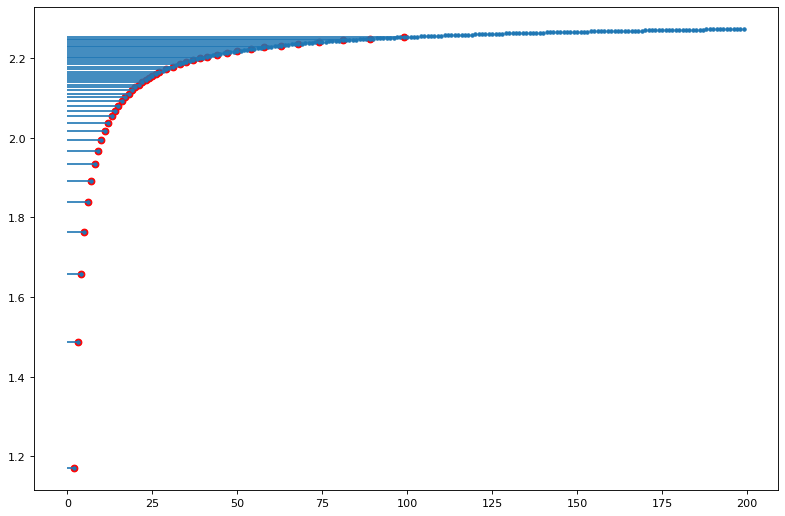

In [17]:
plt.plot(list(NtoT.keys()), list(NtoT.values()), ".")

for n in Ns:
    plt.scatter(n, NtoT[n], c="r")
    plt.hlines(y = NtoT[n], xmin=0, xmax=n)
print(len(Ns))

In [8]:
34*10/512/60*2048

22.666666666666668

In [ ]:
results = []
for N in Ns:
    TcN = NtoT[N]
    Ts = np.linspace(TcN-0.1, TcN+0.1, 4096)
#     Ts = np.linspace(0.5, 3.5, 10*32*3)
    for Ts1 in tqdm(Ts.reshape(32, -1)):
        runs = len(Ts1)
        res = pool.starmap(find_sigma_e, #T, N,M, steps,freq, SEED
                zip(*(Ts1,
                      [N]*runs, # N
                      [4*10**7]*runs, # steps
                      [1]*runs, # freq
                      np.random.randint(0,10**8, runs), # seed
                      [SimulateMH.BoundaryCondition.NotPoriodic]*runs

                          )),
    #             chunksize=1
            )
        results+= res

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

# single

In [5]:
results = []
Ts = np.linspace(0.5, 3.5,10*64)
for Ts1 in tqdm(Ts.reshape(10, 64)):
    runs = len(Ts1)
    res = pool.starmap(find_sigma_e, #T, N,M, steps,freq, SEED
              zip(*(Ts1,
                      [6]*runs, # N
                      [4*10**7]*runs, # steps
                      [1]*runs, # freq
                      np.random.randint(0,10**8, runs), # seed
                      [SimulateMH.BoundaryCondition.NotPoriodic]*runs
                          )),
    #             chunksize=1
            )
    results+= res

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
len(results)

640

In [15]:
with open("heat-capac-6N-4e7-10000.pkl", "rb") as f:
    results = pickle.load(f)

In [16]:
df = pd.DataFrame(results, columns=["N", "temp", "len(Es)", "pos1","pos2", "mean_E", "std_E", "E^3", "E^4"])
df["C"] = df.std_E**2/df.temp**2

In [13]:
df_free = pd.DataFrame(results_free, columns=["N", "temp", "len(Es)", "pos1","pos2", "mean_E", "std_E", "E^3", "E^4"])
df_free["C"] = df_free.std_E**2/df_free.temp**2

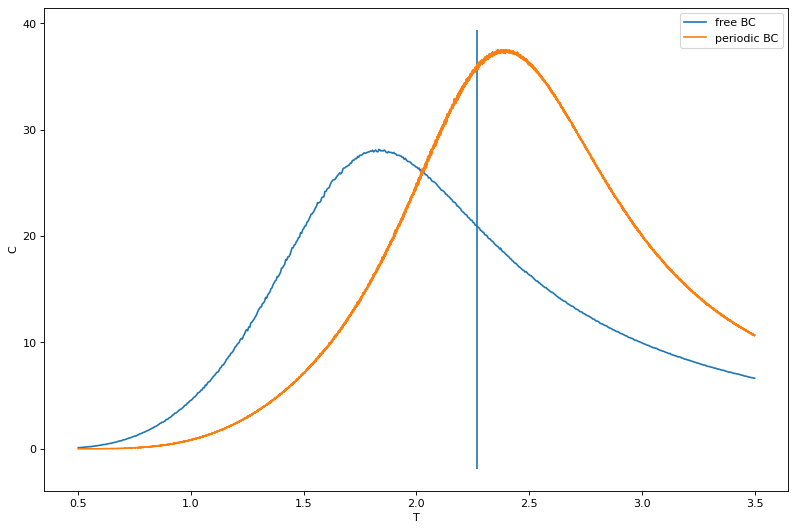

In [18]:
plt.plot(df_free.temp, df_free.C, label="free BC")
plt.plot(df.temp, df.C, label="periodic BC")

plt.vlines(x=TTc, ymin=plt.ylim()[0], ymax=plt.ylim()[1])
plt.xlabel("T")
plt.ylabel("C")
plt.legend()
